# Figure 6B: Plot alignment

We plot the relationship between acceleration and velocity difference, across different alignment conditions.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from itertools import combinations

import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn.functional as functional
from torch.utils.data import random_split
from torch_geometric.data import Batch, Data, DataLoader

In [3]:
import os
import sys

script_path = os.path.realpath(os.path.dirname(__name__))
os.chdir(script_path)
sys.path.append("/workspace/collab-environment/")
sys.path.append("/workspace/collab-environment/collab_env/gnn")
sys.path.append("/workspace/collab-environment/collab_env/data/boids")
sys.path.append("/workspace/collab-environment/figures")

In [4]:
from collab_env.data.boids.animal_simulation import visualize_graph, visualize_pair
from collab_env.gnn.gnn import (get_adjcency_from_debug, plot_log_loss, train_rules_gnn,
    identify_frames, find_frame_sets, load_model, debug_result2prediction)
from utility import handle_discrete_data
from collab_env.gnn.gnn_definition import GNN, Lazy
from collab_env.data.boids.animal_simulation import visualize_graph_2sets

In [5]:
from collab_env.data.file_utils import expand_path, get_project_root

In [8]:
from figures.gnn.plot_helpers import (rollout_to_pos_vel_acc,
    data_to_pos_vel_acc,
    figure_data_B,
    mean_trace_B)

## Data

### a) basic alignment

In [9]:
# basic alignment
data_name = 'boid_single_species_basic'
file_name = f'{data_name}.pt'
config_name = f'{data_name}_config.pt'

dataset = torch.load(expand_path(
        "simulated_data/" + file_name, get_project_root()), weights_only = False)
species_configs = torch.load(expand_path(
        "simulated_data/" + config_name, get_project_root()), weights_only = False)

# weak alignment
data_name_weak = 'boid_single_species_weak_alignment'
file_name_weak = f'{data_name_weak}.pt'
config_name_weak = f'{data_name_weak}_config.pt'

dataset_weak = torch.load(expand_path(
        "simulated_data/" + file_name_weak, get_project_root()), weights_only = False)
species_configs_weak = torch.load(expand_path(
        "simulated_data/" + config_name_weak, get_project_root()), weights_only = False)

# strong alignment
data_name_strong = 'boid_single_species_strong_alignment'
file_name_strong = f'{data_name_strong}.pt'
config_name_strong = f'{data_name_strong}_config.pt'

dataset_strong = torch.load(expand_path(
        "simulated_data/" + file_name_strong, get_project_root()), weights_only = False)
species_configs_strong = torch.load(expand_path(
        "simulated_data/" + config_name_strong, get_project_root()), weights_only = False)

In [10]:
print(f"alignment factor for weak, median, and strong: {
                                                       species_configs_weak["A"]['matching_factor'],
                                                       species_configs["A"]['matching_factor'],
                                                       species_configs_strong["A"]['matching_factor'],
                                                       }"
     )

alignment factor for weak, median, and strong: (0.1, 0.5, 1)


In [11]:
# split data into training set and test set
test_size = int(len(dataset) / 2)
train_size = len(dataset) - test_size

train_dataset, test_dataset = random_split(
    dataset, [train_size, test_size], generator=torch.Generator().manual_seed(2025)
)

# split data into training set and test set
train_dataset_weak, test_dataset_weak = random_split(
    dataset_weak, [train_size, test_size], generator=torch.Generator().manual_seed(2025)
)

# split data into training set and test set
train_dataset_strong, test_dataset_strong = random_split(
    dataset_strong, [train_size, test_size], generator=torch.Generator().manual_seed(2025)
)

In [12]:
# create mini-batches
batch_size = 1
# right now we assume the batch_size = 1, because our real dataset are of different lengths.
# But we can expand to minibatches - except fpr a few specific functions, every function is written with minibatches in mind.
test_loader = DataLoader(test_dataset,
                         batch_size = batch_size, shuffle=False)

test_loader_weak = DataLoader(test_dataset_weak,
                         batch_size = batch_size, shuffle=False)

test_loader_strong = DataLoader(test_dataset_strong,
                         batch_size = batch_size, shuffle=False)

batch = list(iter(test_loader))[0]
pos, species = batch

print("made", str(len(list(test_loader))), "batches, each of size", str(batch_size))  #
print(
    "Batch position:", pos.shape
)  # [Batch size, Number of boids, coordinates (x,y pos)= 2]
print("Species labels:", species.shape)  # [B, N]
print("\n")

made 25 batches, each of size 1
Batch position: torch.Size([1, 1000, 20, 2])
Species labels: torch.Size([1, 20])




/workspace/conda/envs/gnn/lib/python3.13/site-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


## Load models

In [13]:
# load model
models = {}
model_spec = {}
train_spec = {}

for m in ["vpluspplus_a", "lazy"]:
    file_name = f"{data_name}_{m}_noise_{0}" #or a model trained with noise added: f"{data_name}_{m}_noise_{0.001}"
    models[m] = {}
    models[m]["model"], model_spec[m], train_spec[m] = load_model(m, file_name)
    

Loaded model spec.
Loaded training spec.
Loaded model.
Loaded model spec.
Loaded training spec.
Loaded lazy model.


In [14]:
# do rollout
rollout = 5
torch.cuda.empty_cache()

for m in ["vpluspplus_a"]:
    
    gnn_model = models[m]["model"]
    gnn_training_spec = train_spec[m]

    gnn_training_spec["training"] = False
    gnn_training_spec["lr"] = None
    gnn_training_spec["rollout"] = rollout

    # train models basic
    (models[m]["rollout_losses"], _, models[m]["rollout_debug_result"]) = train_rules_gnn(
        gnn_model,
        test_loader,
        species_dim=len(torch.unique(species)),
        **gnn_training_spec
    )


    # train models weak
    (models[m]["rollout_losses_weak"], _, models[m]["rollout_debug_result_weak"]) = train_rules_gnn(
        gnn_model,
        test_loader_weak,
        species_dim=len(torch.unique(species)),
        **gnn_training_spec
    )

    # train models strong
    (models[m]["rollout_losses_strong"], _, models[m]["rollout_debug_result_strong"]) = train_rules_gnn(
        gnn_model,
        test_loader_strong,
        species_dim=len(torch.unique(species)),
        **gnn_training_spec
    )


rolling out...
epoch 0


batch 0




/workspace/collab-environment/collab_env/gnn/gnn.py:388: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  pos = torch.tensor(pos)
/workspace/collab-environment/collab_env/gnn/gnn.py:389: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  vel = torch.tensor(vel)
/workspace/collab-environment/collab_env/gnn/gnn.py:390: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  acc = torch.tensor(acc)
/workspace/collab-environment/collab_env/gnn/gnn.py:454: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or so

batch 1


batch 2


batch 3


batch 4


batch 5


batch 6


batch 7


batch 8


batch 9


batch 10


batch 11


batch 12


batch 13


batch 14


batch 15


batch 16


batch 17


batch 18


batch 19


batch 20


batch 21


batch 22


batch 23


batch 24


Epoch 000 | Train: 24.3971
rolling out...
epoch 0


batch 0


batch 1


batch 2


batch 3


batch 4


batch 5


batch 6


batch 7


batch 8


batch 9


batch 10


batch 11


batch 12


batch 13


batch 14


batch 15


batch 16


batch 17


batch 18


batch 19


batch 20


batch 21


batch 22


batch 23


batch 24


Epoch 000 | Train: 7.1781
rolling out...
epoch 0


batch 0


batch 1


batch 2


batch 3


batch 4


batch 5


batch 6


batch 7


batch 8


batch 9


batch 10


batch 11


batch 12


batch 13


batch 14


batch 15


batch 16


batch 17


batch 18


batch 19


batch 20


batch 21


batch 22


batch 23


batch 24


Epoch 000 | Train: 36.2197


In [22]:
thresholds = np.linspace(0.01, 0.1, 20) 
#the threshold for spatial range, within which we consider boid rule. 0.1 is chosen as this is the boid visual range during simulation

plotting_kwargs = {
    "starting_frame": 5,
    "ending_frame": 15,
    "version": "boids" #"singleton"
}

In [23]:
mean_all, mean_weak_all, mean_strong_all = [], [], []
mean_model_all, mean_model_weak_all, mean_model_strong_all = [], [], []

bins_all, bins_weak_all, bins_strong_all = [], [], []
bins_model_all, bins_model_weak_all, bins_model_strong_all = [], [], []

for t in thresholds:
    plotting_kwargs["threshold"] = t
    plotting_kwargs["model"] = False
    
    """data"""
    del_v, acc_ = figure_data_B(test_loader, None, **plotting_kwargs)
    bins, mean, sd = mean_trace_B(del_v, acc_)
    
    del_v_weak, acc_weak = figure_data_B(test_loader_weak, None, **plotting_kwargs)
    bins_weak, mean_weak, sd_weak = mean_trace_B(del_v_weak, acc_weak)
    
    del_v_strong, acc_strong = figure_data_B(test_loader_strong, None, **plotting_kwargs)
    bins_strong, mean_strong, sd_strong = mean_trace_B(del_v_strong, acc_strong)

    mean_all.append(mean)
    mean_weak_all.append(mean_weak)
    mean_strong_all.append(mean_strong)

    bins_all.append(bins)
    bins_weak_all.append(bins_weak)
    bins_strong_all.append(bins_strong)

    """model"""
    plotting_kwargs["model"] = True
    
    del_v_model, acc_model = figure_data_B(None, models[m]["rollout_debug_result"], **plotting_kwargs)
    bins_model, mean_model, sd_model = mean_trace_B(del_v_model, acc_model)
    
    del_v_model_weak, acc_model_weak = figure_data_B(None, models[m]["rollout_debug_result_weak"], **plotting_kwargs)
    bins_model_weak, mean_model_weak, sd_model_weak = mean_trace_B(del_v_model_weak, acc_model_weak)
    
    del_v_model_strong, acc_model_strong = figure_data_B(None, models[m]["rollout_debug_result_strong"], **plotting_kwargs)
    bins_model_strong, mean_model_strong, sd_model_strong = mean_trace_B(del_v_model_strong, acc_model_strong)

    mean_model_all.append(mean_model)
    mean_model_weak_all.append(mean_model_weak)
    mean_model_strong_all.append(mean_model_strong)

    bins_model_all.append(bins_model)
    bins_model_weak_all.append(bins_model_weak)
    bins_model_strong_all.append(bins_model_strong)

    #ax.scatter(del_v, acc_, s = 5, alpha = 0.5)



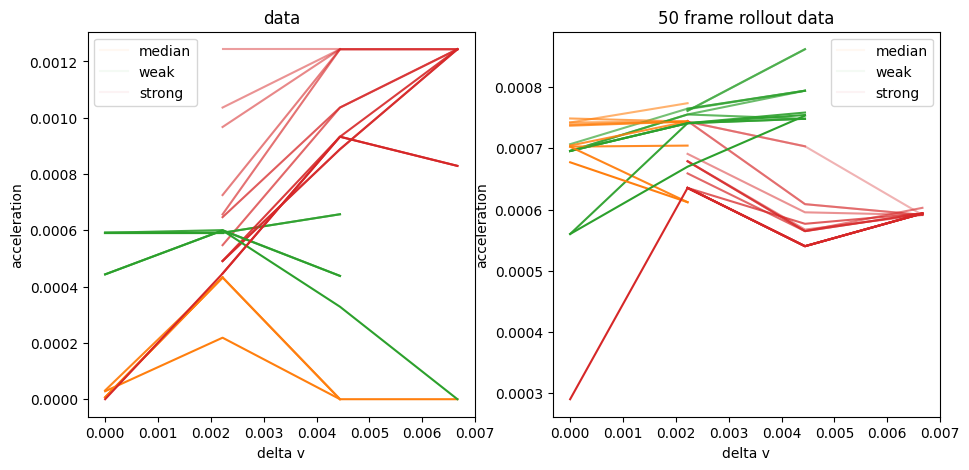

In [24]:
fig, axes = plt.subplots(1,2,figsize=(11, 5))


ax = axes[0]
for t_ind in range(len(thresholds)):

    bins = bins_all[t_ind]
    mean = mean_all[t_ind]

    if t_ind == 0:
        label = "median"
    else:
        label = None
    ax.plot(bins, mean, 'C1', label = label, alpha = 0.05 * (t_ind + 1))
    
    mean_weak = mean_weak_all[t_ind]
    bins_weak = bins_weak_all[t_ind]

    if t_ind == 0:
        label = "weak"
    else:
        label = None
    ax.plot(bins_weak, mean_weak, 'C2', label = label, alpha = 0.05 * (t_ind + 1))
    
    mean_strong = mean_strong_all[t_ind]
    bins_strong = bins_strong_all[t_ind]
    if t_ind == 0:
        label = "strong"
    else:
        label = None
    ax.plot(bins_strong, mean_strong, 'C3', label = label, alpha = 0.05 * (t_ind + 1))


    ax2 = axes[1]

    bins = bins_model_all[t_ind]
    mean = mean_model_all[t_ind]
    if t_ind == 0:
        label = "median"
    else:
        label = None
    ax2.plot(bins, mean, 'C1', label = label, alpha = 0.05 * (t_ind + 1) )
    
    mean_weak = mean_model_weak_all[t_ind]
    bins_weak = bins_model_weak_all[t_ind]
    if t_ind == 0:
        label = "weak"
    else:
        label = None
    ax2.plot(bins_weak, mean_weak, 'C2', label = label, alpha = 0.05 * (t_ind + 1))
    
    mean_strong = mean_model_strong_all[t_ind]
    bins_strong = bins_model_strong_all[t_ind]
    if t_ind == 0:
        label = "strong"
    else:
        label = None
    ax2.plot(bins_strong, mean_strong, 'C3', label = label, alpha = 0.05 * (t_ind + 1))


#ax.fill_between(bins, mean - sd, mean + sd, alpha = 0.5)
#ax.fill_between(bins_weak, mean_weak - sd_weak, mean_weak + sd_weak, alpha = 0.5)
ax.set_title("data")
ax2.set_title("50 frame rollout data")
ax.set_xlabel("delta v")
ax2.set_xlabel("delta v")

ax.set_ylabel("acceleration")
ax2.set_ylabel("acceleration")

ax.legend()
ax2.legend()

plt.show()